# DU-GD法 (リッジ回帰問題)

Copyright (c) 2022 Tadashi Wadayama  
Released under the MIT license  
https://opensource.org/licenses/mit-license.php

In [1]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux

### 準備 (グローバル定数の設定)

In [2]:
n = 50　
m = 100　
num_itr = 50
K = 100
λ = 3.0
adam_lr1 = 1e-4
adam_lr2 = 1e-2
max_inner = 50

A = randn(m,n)
Pinv = (A'*A + λ*I)^(-1)*A'
eig = eigvals(A'*A + λ*I)
λmin = minimum(eig)
λmax = maximum(eig)
ηopt = 2/(λmin + λmax)

0.006694933486638095

### ミニバッチ生成関数

In [3]:
function mini_batch(K)
    y = randn(m,K)
    x_opt = Pinv*y
    return y, x_opt
end

mini_batch (generic function with 1 method)

### 固定ステップサイズのGD法のMSE

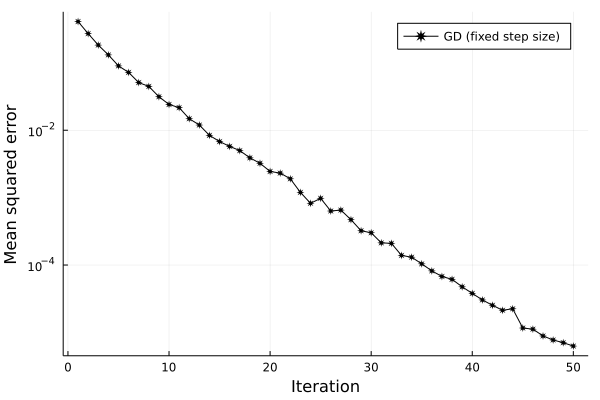

In [4]:
function GD(max_itr, y)
    x = zeros(n, K)
    for i in 1:max_itr
        x = x - ηopt*(A'*(A*x - y) + λ*x)
    end
    return return x
end

function comp_mse(max_itr)
    y, x_opt = mini_batch(K)
    x̂ = GD(max_itr, y)
    return norm(x_opt - x̂)^2/K
end
        
GD_mse = [comp_mse(i) for i in 1:num_itr]
plot(1:num_itr, GD_mse, lw=1, yscale=:log10, label="GD (fixed step size)", marker=:star8, color=:black, xlabel="Iteration", ylabel="Mean squared error")

### DU-GD反復の定義 

In [5]:
function DU_GD(max_itr, y, η, ξ, enable_ξ)
    x = zeros(n, K)
    for i in 0:max_itr-1
        k = (i % T)+1
        if enable_ξ == true 
            x = x - η[k]*(A'*(A*x -y) + abs.(ξ[i+1])*x)
        else 
            x = x - η[k]*(A'*(A*x -y) + λ*x)
        end
    end
    return x
end

DU_GD (generic function with 1 method)

### 損失関数の定義

In [6]:
function loss(x_opt, x̂)
    return norm(x_opt - x̂)^2/K
end     

loss (generic function with 1 method)

### 訓練関数の定義

In [7]:
function train(η, ξ, enable_ξ)
    ps1 = params(η) 
    ps2 = params(ξ) 
    opt1 = ADAM(adam_lr1)
    opt2 = ADAM(adam_lr2)
    
    for itr in 1:num_itr # outer loop
        for i in 1:max_inner # inner loop
            y, x_opt = mini_batch(K)
            gs = gradient(()->loss(x_opt, DU_GD(itr, y, η, ξ, enable_ξ)), ps1) 
            Flux.Optimise.update!(opt1, ps1, gs) 
            gs = gradient(()->loss(x_opt, DU_GD(itr, y, η, ξ, enable_ξ)), ps2) 
            Flux.Optimise.update!(opt2, ps2, gs) 

        end
        # check for temporal MSE
        y, x_opt = mini_batch(K)
        x̂ = DU_GD(itr, y, η, ξ, enable_ξ)
        println(itr, " ", loss(x_opt, x̂))
    end
end

train (generic function with 1 method)

### DU-GDのMSE評価用関数

In [8]:
function comp_mse_DUGD(max_itr, η, ξ, enable_ξ)
    y, x_opt = mini_batch(K)
    x̂ = DU_GD(max_itr, y, η, ξ, enable_ξ)
    return loss(x_opt, x̂)
end

comp_mse_DUGD (generic function with 1 method)

### $\xi^{(t)} = \lambda$と固定、ステップサイズは学習する

1 0.4707982947882954
2 0.2548170965785649
3 0.14577268041379182
4 0.10539068222682975
5 0.059884523098715246
6 0.03537539237406492
7 0.022092613092157723
8 0.01649445020935311
9 0.011767345708636846
10 0.006020557129822156
11 0.004829850171399608
12 0.003768953053728838
13 0.002146118886013425
14 0.001085265706894048
15 0.001155958549611646
16 0.0008145135659059402
17 0.0005489339211606464
18 0.00037770959180595065
19 0.00024386870642862407
20 0.00021026456477510542
21 0.00015672536457482806
22 0.00010377863805617914
23 8.657030946344844e-5
24 5.4714841498346555e-5
25 3.5735983386442775e-5
26 2.5242262257039537e-5
27 1.999087924856272e-5
28 1.7383940787497326e-5
29 1.3542488070810098e-5
30 6.610854961996385e-6
31 4.6861302313799154e-6
32 4.253252918814342e-6
33 2.7162291844496884e-6
34 2.048254564050827e-6
35 1.811655515458125e-6
36 1.137175380551037e-6
37 1.0879788240265507e-6
38 5.604810156042244e-7
39 4.606215445492079e-7
40 3.7757338179171163e-7
41 2.3308215373108244e-7
42 1.476523

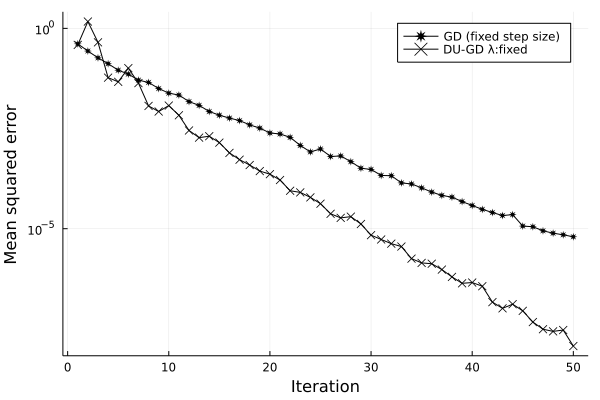

In [9]:
T = 4
enable_ξ = false
η_train = zeros(num_itr) 
ξ_train = λ*ones(num_itr) 
train(η_train, ξ_train, enable_ξ)
DUGD_mse =[comp_mse_DUGD(i, η_train, ξ_train, enable_ξ) for i in 1:num_itr]
plot!(1:num_itr, DUGD_mse, lw=1, label="DU-GD λ:fixed", color=:black, marker=:x)

### 学習過程 $\xi^{(t)}$を学習

In [10]:
enable_ξ = true
η_train = zeros(num_itr) 
ξ_train = λ*ones(num_itr) 
train(η_train, ξ_train, enable_ξ)
ξ_train

1 0.48636263300252297
2 0.24924485952265016
3 0.15499217486254738
4 0.09493916192437551
5 0.05279996560265813
6 0.028290745772310257
7 0.018291128248380473
8 0.009018524748055451
9 0.006193754781392854
10 0.0026960855893534918
11 0.002462227883313832
12 0.0014362350768797251
13 0.0008275428686547394
14 0.0004564963568112347
15 0.00027648859864827616
16 0.00019896718250372316
17 0.0001400849409642751
18 5.3620569384910265e-5
19 4.1370572367030526e-5
20 3.1194022778817034e-5
21 1.8421442197208316e-5
22 7.417559464421357e-6
23 5.953461159579912e-6
24 5.104916646289325e-6
25 2.783132455769145e-6
26 1.21018559529758e-6
27 1.04971090490272e-6
28 8.794462864382869e-7
29 5.797794553595141e-7
30 2.5325741892452633e-7
31 1.8830095332959754e-7
32 1.5598773369222321e-7
33 9.73436591456957e-8
34 3.9970183223705486e-8
35 3.241632356131094e-8
36 2.954781265294839e-8
37 1.9562938733843122e-8
38 9.190173792977016e-9
39 6.8910101048915245e-9
40 5.42083571344887e-9
41 3.7765623116864374e-9
42 2.359678011

50-element Vector{Float64}:
  3.0
 -3.060045281007571e-9
  0.01581289555963941
  0.49981905551234773
 -6.801414540853861e-9
 -1.6517313295722997e-7
  2.3129589611966604e-7
  2.852292631968169e-7
 -8.565848421219164e-7
  0.45034800140944653
 -1.7665391079447213e-6
  1.1193493636667973
  1.1101140979853323
  ⋮
  3.0078553738634364
  3.0019308128213327
  3.0030334067926026
  3.001036290675038
  3.0022682981686906
  3.0007314071985545
  3.0002368823424033
  3.0000555406645306
  3.0000744260080534
  3.0009060220322854
  2.9991701686136145
  3.0007280485086096

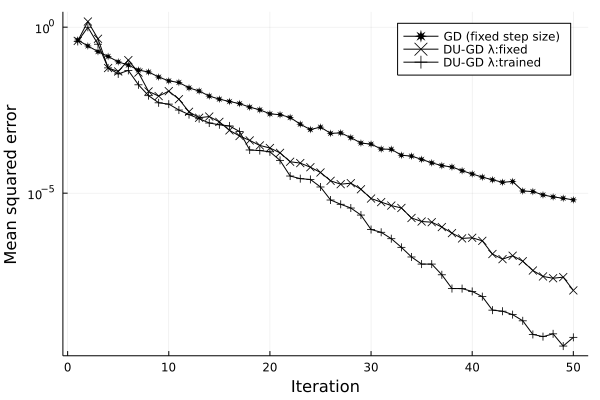

In [11]:
DUGD_mse =[comp_mse_DUGD(i, η_train, ξ_train, enable_ξ) for i in 1:num_itr]
plot!(1:num_itr, DUGD_mse, lw=1, label="DU-GD λ:trained", color=:black, marker=:+)

In [12]:
savefig("DU-GD-Ridge.pdf")

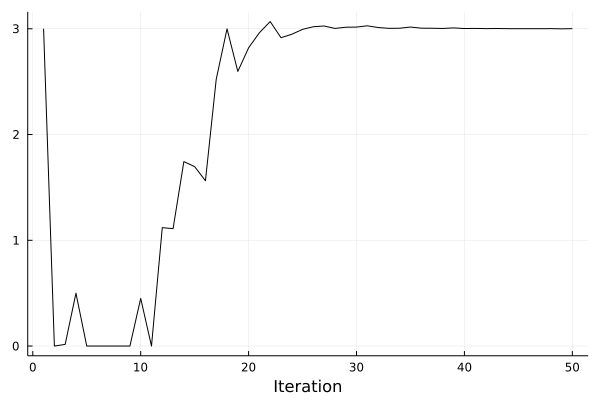

In [13]:
plot(1:num_itr, abs.(ξ_train), xlabel="Iteration", color=:black, legend=false)

In [14]:
savefig("DU-GD-Ridge-param.pdf")